In [3]:
!pip install -U fastai

ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.0.1 which is incompatible.



  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19196 sha256=f99991c323620dd0a089ef276428b35e9f90d8a6f8d49cbff4dc722b4edcda69
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\df\99\da\c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3


In [3]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re
import string
import torch
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
train = pd.read_csv('Train.csv', index_col='tweetid')

In [5]:
train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


Text(0.5, 1.0, 'Tweet length distribution')

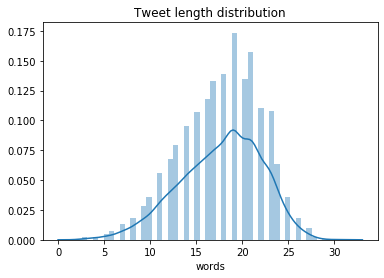

In [32]:
#plot tweet word length distribution
import seaborn as sns
plt.figure()
sns.distplot(train['words']).set_title('Tweet length distribution')

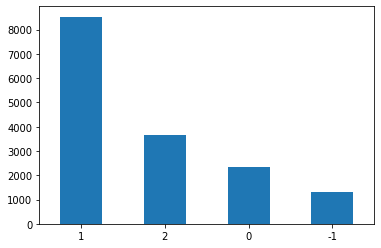

In [78]:
#plot sentiment distribution
train['sentiment'].value_counts().plot.bar(rot = 0)

In [7]:
#Preprocessing the data for topic modeeling reasons
#Not the final text cleaning. Created to see a rough output of what still neededc to be fiuxed befor a proper analysis is done on the returned results

#cleaning functions
from nltk.stem import WordNetLemmatizer

#stop words
stop2 = text.ENGLISH_STOP_WORDS
stop = set(stopwords.words('english'))

#create mention list
def m_fin(text):
    mentions = []
    men_f = re.compile(r'@([a-zA-Z0-9-z#_]+)')
    for word in text:
         mentions = men_f.findall(text)
    return mentions

#create hashtag list
def hash_finder(tweet):
    hashes = []
    finder = re.compile(r'#([a-zA-Z0-9-z#_]+)')
    for word in tweet:
        hashes = finder.findall(tweet)
    return hashes

#create url list
def url_fr(text):
    url = re.compile(r"([https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,}])")
    for link in text:
        found = url.findall(text)
    return found

#precleaning
def clean_text(text):
    text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "", text)

    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove 
    #text_nomen = re.sub(r'(@[a-zA-Z0-9-z#_]+)','', text_nonum)
    text_nohash = re.sub(r'(#[a-zA-Z0-9-z#_]+)', '', text_nonum)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char.lower() for char in text_nohash if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # Also, removes leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

#lemmetize
def lemm(word):
    lemme = WordNetLemmatizer()
    result = lemme.lemmatize(word)
        #result = wordnet.morphy(word)
        #if result is None:
        #    return word
        #else: return result
    return result
#remove stop words
def tokenizer_2(tokenized):
    tokenized = word_tokenize(tokenized)
    tokenized = [t for t in tokenized if (t not in  stop and t not in stop2 and len(t) > 1)]
    tokenized = [lemm(t) for t in tokenized]
    return tokenized

#tweet word length
def counter(text):
    # remove numbers
    holder =[]
    holder = text.split()
    count = len(holder)
    return count
train['words'] =  train['message'].apply(counter)
train['tags'] = train['message'].apply(hash_finder)
train['url'] = train['message'].apply(url_fr)
train['cleaned'] = train['message'].apply(clean_text)
train['for_vect'] = train['cleaned'].apply(tokenizer_2)

In [8]:
#quick check on the output data inorder to see what we are going to manipulate 
train.head()

,sentiment,message,words,tags,url,cleaned,for_vect
tweetid,,,,,,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...,19,[],[https://t.co/yeLvcEFXkC],polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
126103,1,It's not like we lack evidence of anthropogeni...,10,[],[],its not like we lack evidence of anthropogenic...,"[like, lack, evidence, anthropogenic, global, ..."
698562,2,RT @RawStory: Researchers say we have three ye...,19,[],"[https://t.co/WdT0KdUr2f, https://t.co/Z0ANPT…]",rt rawstory researchers say we have three year...,"[rt, rawstory, researcher, say, year, act, cli..."
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,15,[TodayinMaker#],[https://t.co/44wOTxTLcD],wired was a pivotal year in the war on climate...,"[wired, pivotal, year, war, climate, change]"
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",18,[ElectionNight],[],rt soynoviodetodas its and a racist sexist cli...,"[rt, soynoviodetodas, racist, sexist, climate,..."


In [8]:
!pip install gensim

In [1]:
#using Gensim library to create the topic modelling and also to give us tasty visualizations at the end
from gensim import models
from gensim.corpora import Dictionary, MmCorpus

In [13]:
#creating our corpus of words to use in our topic modelling algorithm
#rememebr to check tghe cleaning done to the text and the way inh wich they are tokenized as this will determine the corpus we create here
dictionary = Dictionary(train['for_vect'])
stopwords = stop.union(stop2, ['s'])
stop_ids =map(dictionary.token2id.get, stopwords)
dictionary.filter_tokens(stopwords)
dictionary.compactify()
dictionary.filter_extremes(no_below =2, no_above=5,keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in train['for_vect']]

#serializing corpus
MmCorpus.serialize('TweetCorp.mm', corpus)

#save dictionary
dictionary.save('TweetCorp.dict')

In [55]:
saver = pd.DataFrame(data = (train[['sentiment', 'cleaned']]), copy = True)
saver.to_csv('saver.csv', header = False, index = False)

In [56]:
path = './'
data_lm = TextLMDataBunch.from_csv(path , 'saver.csv', min_freq=1)

In [57]:
data_lm.save()

In [59]:
#using bnuiltin in tokeninzer to identify key topics and words in the cleaned messages. NOT A FINAL CLEAN. FOR DEMO PURPOSES

data_lm.show_batch()

idx,text
0,sofaking khoublake fahrenthold foxnews cnn weatherchannel gaughansurfing just keep repeating climate change is a l … xxbos rt frankieboyle lets look on the bright side maybe climate change will kill off humanity before a global fascist government can start tã¢â‚¬â ¦ xxbos rt arthur the great american disconnect with global warming xxbos world leaders duped by manipulated global warming data realdonaldtrump spot on with your gut feelings xxbos rt planetgreen
1,other climate change issues is an effective tool xxbos rt mishacollins good point realdonaldtrump is the candidate who might end global warming by bringing us nuclear winter do nt beã¢â‚¬â ¦ xxbos rt billnye just a little climate change what s a few billion here or there xxbos rt tveitdal china blames climate change for record sea levels xxbos call your senators tell them to block trump ’s cabinet of
2,yearsofliving c on natgeochannel xxbos rt glenont the huge weight of working on climate change is that once you know the science amp how little time we have to act u ca nt ever … xxbos the epa is planning a debate about climate change but bill nye says that debates already been settled xxbos climate change is real climate change is real climate change is real climate change is
3,warming researchers say xxbos rt gadsaad hey billnye you are off the hook its due to boredom not climate change we found the culprit xxbos rt greenpeacenz were the last generation that can stop climate change rise up end oil xxbos derds peterbaynham also he believes global warming is a myth that alone might wipe us all out xxbos new research points out that climate change will increase fire activity
4,the us or not h … xxbos rt sensanders we have a presidentelect who does nt believe in climate change millions of people are going to have to say mr tã¢â‚¬â ¦ xxbos epascottpruitt does nt think co drives climate change lets send him a copy of global warming for dummies xxbos rt altnatparkser trump knows climate change is real he just does nt care for deniers ignoring these worries


In [63]:
#using a pretrained mdoel to add weights to the 
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult =0.1)

In [64]:
#model summary. CPU time killer
list(learner.model.children())

[AWD_LSTM(
   (encoder): Embedding(20352, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(20352, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ),
 LinearDecoder(
   (decoder): Linear(in_features=400, out_features=20352, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


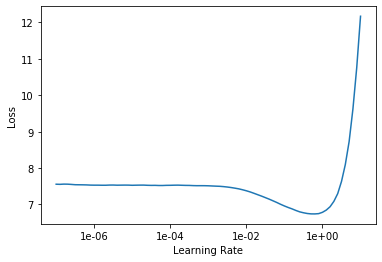

In [65]:
#finding optimum learning rate using builtin method
earner.lr_find(start_lr=1e-8,end_lr=1e2)
learner.recorder.plot()

In [67]:
#initial fitting f the model to the discovered optimum learning rate
learner = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, 
                               drop_mult=0.5)
learner.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.170508,6.305771,0.159997,04:34


In [68]:
#training Fine tunig layer for tranfer learning model. DO NOT RUN unless you have ~3hrs free
earner.unfreeze()
learner.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.005454,5.260225,0.241151,09:45
1,5.521070,4.923249,0.298661,09:50
2,5.149958,4.711720,0.325159,09:49
3,4.805647,4.442574,0.353237,09:47
4,4.459412,4.276330,0.375207,09:45
5,4.164099,4.196540,0.387293,09:44
6,3.818976,4.173489,0.398214,09:52
7,3.486273,4.183774,0.403013,09:54
8,3.191787,4.177151,0.409598,09:51
9,2.916767,4.227705,0.409040,10:27


In [69]:
#Saving the fine tuning layer created in the previous block
learner.save_encoder('ft_enc')


In [8]:
#test and train
from sklearn.model_selection import train_test_split
X, validation_x, Y, validation_y = train_test_split(train.cleaned, train.sentiment, test_size=0.30, shuffle = True, random_state=32)
train_text, test_text, train_val, test_val = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=32)



In [100]:
#did a quick check using a different model to see what effect the data cleaning had. A lot faster than constantly having to run the transfer model after changes
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

clasif = Pipeline([('vect', CountVectorizer(stop_words=stop2)),('tfid', TfidfTransformer()),(
                 'svm', SGDClassifier(loss='hinge', penalty ='l2', alpha=1e-3, max_iter=5, random_state=32))])
clasif = clasif.fit(train_text, train_val)
y_pred = clasif.predict(validation_x)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [18]:
y_pred

array([2, 1, 1, 1, ..., 1, 1, 1, 2], dtype=int64)

In [19]:
np.mean(y_pred == validation_y)

0.6609776654024442

In [24]:
#Created this supervised model where we chose an arbitasry amount of topics for the tweets. Done to check if we are getting reasonable results with the unsupervised model beelow
#creating LDA model for cat analysis
from sklearn.decomposition import LatentDirichletAllocation
# Build LDA Model
lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                     id2word = dictionary,
                                     num_topics = 4,
                                     eval_every = 10,
                                     passes=50,
                                     iterations=5000,
                                     random_state=32)


In [25]:
#preparing the model for display
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data1 = gensimvis.prepare(lda_model, corpus, dictionary)

In [27]:
pyLDAvis.display(vis_data1)

In [30]:
#using an unsupervised Heirarchical Dirichlet Process model to determine topics
# The optional parameter T here indicates that HDP should find no more than 50 topics
# if there exists any.
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=50)
hdp.save('newsgroups_hdp.model')

In [31]:
vis_data = gensimvis.prepare(hdp, corpus, dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes


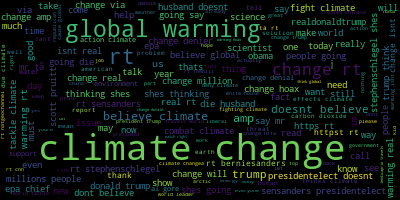

In [101]:
#quick analysis of the cleaned tweet data
from wordcloud import WordCloud

#strings we will wqork with from lemmetized text
analysis_strings = ','.join(list(train['cleaned'].values))

#WordCloud object
wc = WordCloud(background_color='black', max_words=200, contour_width=3,contour_color='steelblue')
wc.generate(analysis_strings)

#display created WordCloud
wc.to_image()

In [125]:
#plottig most common words
#lot of this comes from stackoverflow
def plotter(count_data, vectorizer):
    words_plot = vect.get_feature_names()
    total = np.zeros(len(words_plot))
    for t in count_data:
        total+=t.toarray()[0]
    count_dict = (zip(words_plot, total))
    count_dict = sorted(count_dict,key=lambda x:x[1],reverse=True)[0:20]
    words_plot = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words_plot))
    
    plt.figure(2, figsize=(10, 5))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words_plot, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

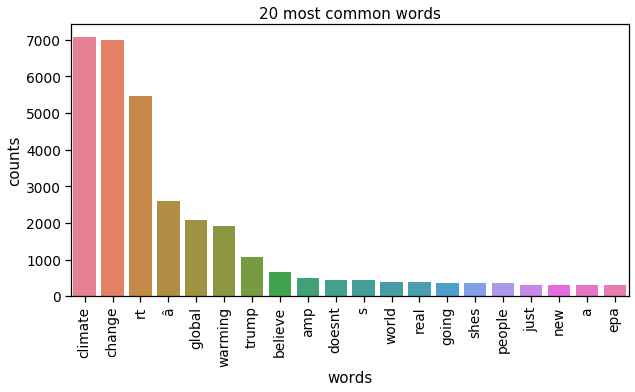

In [126]:
plotter(xtrain_vect, vect)

In [111]:
#vectorizing for lda using count vectorizer
vect = CountVectorizer(stop_words = stop2, analyzer = 'word', token_pattern=r'\w{1,}')
vect.fit(train['cleaned'])

xtrain_vect = vect.transform(train_text)
xvalid_vect = vect.transform(validation_x)
#x_val = t_vector.transform(test_text)

In [139]:
#quick topic modelling
#also extracting topics per tweet to bu used as features
#train LDA Model to start a quick topic analysis
from sklearn import decomposition
from sklearn.decomposition import *

lda_model = decomposition.LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20)
tweet_topics= lda_model.fit(xtrain_vect)
found_topics= lda_model.components_
vocab = vect.get_feature_names()

#view k top topics
k = 10
topic_sum = []
for i, dist in enumerate(found_topics):
    found_topic = np.array(vocab)[np.argsort(dist)][:-(k+1):-1]
    topic_sum.append(''.join(found_topic))

In [140]:
#printing quick LDA tpoic model analysis results
#lda_model.fit(xtrain_vect)
#print(tweet_topics, vect, k)
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, vect, 10)

Topics found via LDA:

Topic #0:
planet good future exxon berniesanders tillerson used rex clinton discuss

Topic #1:
epa years pruitt scott hes head chief rights carbon denies

Topic #2:
https does said data youre manmade g debate literally role

Topic #3:
change climate rt new news trump research house white study

Topic #4:
global warming rt dont science think real make like realdonaldtrump

Topic #5:
climate change rt â trump believe doesnt s going shes

Topic #6:
climate change isnt help thing deniers report water did read

Topic #7:
making americans impacts thought public fucking huffpostpol having entire nice

Topic #8:
stop guardian story battle hell using opinion f invented chance

Topic #9:
new cause want ice leaders says evidence al arctic gore


In [141]:
!pip install pyLDAvis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=b2e9b5eb12798d4d3108a4c18fdcd385017e1f6453bb1287812fbf3e2c0bb361
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\3b\fb\41\e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32045 sha256=627624b27bc1fc4cdb7fda4c31c24b1b14d1b8ea160b1b0686cc8f4419719d5e
  Stored in directory: c:\users\kwande\appdata\local\pip\cache\wheels\3c\33\97\805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAvis funcy


In [144]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle

In [146]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(10))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = sklearn_lda.prepare(lda_model, xtrain_vect, vect)
with open(LDAvis_data_filepath, 'w') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')


TypeError: write() argument must be str, not bytes